# 5-1. 검증세트를 나누고 전처리 과정을 배웁니다

- 훈련세트는 fit()메서드에 전달되어 모델을 훈련하는 데 사용
- 테스트 세트는 score()메서드에 전달해 모델의 성능을 평가
- 어느 데이터 세트에만 치우친 모델을 만들지 않는 것을 목표로 테스트 세트 사용 방법 알아보기

## 테스트 세트로 모델을 튜닝합니다

> 로지스틱 회귀로 모델 훈련하고 평가하기

In [1]:
# cancer dataset을 읽어들여 훈련세트와 테스트세트로 나눕니다
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [2]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

- 정확도는 83% 정도
- 성능이 만족스럽지 않다면 손실함수를 바꾸어볼 수 있음
- 사용자가 직접 변경해야 하는 값을 하이퍼 파라미터라고 함

> 서포트 벡터 머신으로 모델 훈련하고 평가하기

- SGDClassifier 클래스의 loss 매개변수를 log에서 hinge로 바꾸면 선형 서포트 벡터 머신 문제를 푸는 모델이 만들어짐
- SVM이란 '훈련 데이터의 클래스를 구분하는 경계선을 찾는 작업' 정도로 이해할 수 있음

In [5]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

- 성능평가 결과 93% 정도의 정확도가 나옴
- 로지스틱 회귀 모델보다 좋아짐
- 성능이 좋지 않을 때는 SGDClassifier의 다른 매개변수들을 바꾸어 보면 됨
- 이런 작업을 '모델을 튜닝한다'라고 함
- 이 모델은 실전에서 좋은 성능을 내지 못할 확률이 큼. 왜그럴까?

## 테스트 세트로 모델을 튜닝하면 실전에서 좋은 성능을 기대하기 어렵습니다.

- 테스트 세트는 실전에 투입된 모델의 성능을 측정하기 위해 사용함
- 그런데 이 테스트 세트로 모델을 튜닝하면 '테스트세트에 대해서만 좋은 성능을 보여주는 모델'이 만들어질 수 있음
- 테스트 세트로 모델을 튜닝하는 것을 '테스트 세트의 정보가 모델에 새어 나갔다'라고 말함
- 일반화 성능에 왜곡이 생길 수 있음

## 검증세트를 준비합니다.

- 모델을 튜닝할 때 테스트 세트를 사용하지 않으면 문제는 간단해짐
- 하지만 모델을 튜닝하려면 성능점수가 필요함
- 모델 튜닝을 위한 세트를 따로 준비하자! -> 검증세트 (validation_set)
- 훈련세트를 60%, 검증세트를 20%, 테스트 세트를 20%로 나누기

- 저자의 메모: 훈련세트가 너무 작아져도 곤란합니다
    - 검증 세트를 위해 훈련세트를 줄이면 학습을 위한 훈련데이터가 부족할 수 도 있음

> 1. 데이터 세트 준비하기

In [22]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

> 2. 검증세트 분할하기

In [23]:
x_train_all.shape, y_train_all.shape

((455, 30), (455,))

In [24]:
# train_all 변수를 다시 8:2로 나누어 validation set을 만들어 줌
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train), len(x_val))

364 91


- 455개의 훈련세트를 8:2 비율로 나누어서 x_train은 364개, x_val은 91개가 됨

> 3. 검증세트 사용해 모델 평가하기

In [25]:
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

0.6923076923076923

- 앞에서 나왔던 정확도보다 낮아짐
- 위스콘신 유방암데이터의 샘플은 적은 편
- 원래 적은 데이터로 validation set까지 만들려니 학습에 사용할 데이터가 별로 없었던 것
- 데이터 양이 너무 적은 경우는 검증세트를 별도로 두지 않고 교차검증(cross validation)을 실시함
- 10만개 정도의 데이터는 8:1:1 정도로 분할하고
- 100만개 이상의 데이터는 98:1:1 정도의 비율로 샘플을 나눔

## 데이터 전처리와 특성의 스케일을 알아봅니다.

- 실제 수집된 데이터에는 누락된 값이 있을 수 있고 형태가 균일하지 않을 수 있음
- 전처리에 대해 알아보겠음

> 특성의 스케일은 알고리즘에 영향을 줍니다

- 잘 정리된 데이터도 전처리를 해야하는 경우가 있는데, 이는 특성의 스케일이 다른 경우임
- 특성의 스케일이란 해당 특성이 가지고 있는 값의 범위를 말함
- 당도와 무게를 비교해보면 당도의 범위는 1~10, 무게의 범위는 500~1000으로 스케일 차이가 큼을 알 수 있음
- 어떤 알고리즘은 스케일에 민감하여 모델성능에 영향을 줄 수 있음
- 이 책의 신경망 알고리즘들은 모두 경사하강법을 이용함
- 경사하강법은 스케일에 민감하므로 스케일을 맞추는 전처리가 필요함
- 이런 활동을 '스케일을 조정한다'라고 표현함

## 스케일을 조정하지 않고 모델을 훈련해볼까요?

> 1. 훈련 데이터 준비하고 스케일 비교하기

- 위스콘신 유방암 데이터와 4장에서 만든 단일층 신경망 모델을 사용함
- 특성의 스케일을 비교해야 하므로 유방암 데이터의 mean perimeter와 mean area특성을 활용
- 박스플롯으로 두 특성의 스케일 확인

['mean perimeter' 'mean area']


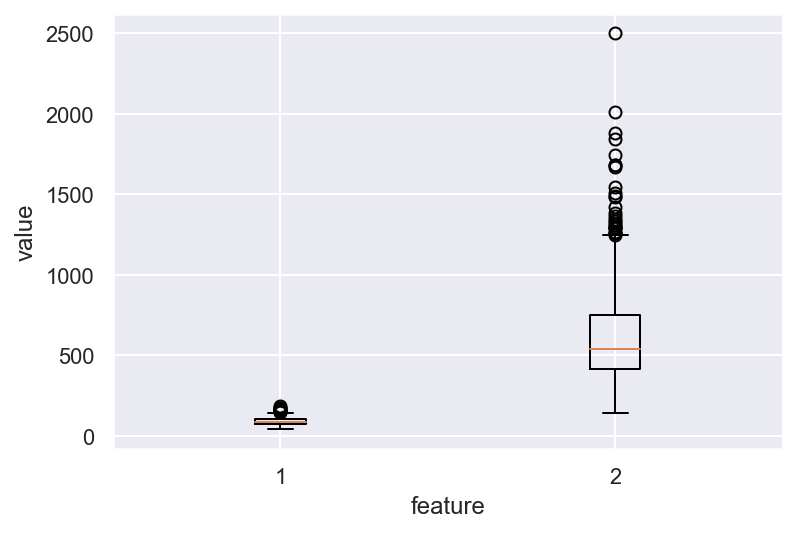

In [27]:
import matplotlib.pyplot as plt
print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

- mean perimeter는 주로 100-200사이의 값을 갖고, mean area는 주로 200-2000 사이의 값을 가짐

> 2. 가중치를 기록할 변수와 학습률 파라미터 추가하기

- SingleLayer 클래스에 인스턴스 변수를 추가하여 에포크마다 가중치의 값을 저장하고 변화를 관찰
- 학습률이라는 개념 도입
    - 가중치의 업데이트 양을 조절
    - 일반적으로 손실함수는 굴곡이 복잡한 형태
    - 가중치를 큰 폭으로 업데이트하여 손실함수가 최소가 될 수 있는 지점인 전역 최솟값을 지나쳐 버리면 최적의 해를 구할 수 없게 됨
    - 전역 최소값을 지나치지 않도록 가중치의 업데이트 양을 조절할 필요
    - 문제마다 적절한 학습률은 다르지만 보통 0.001, 0.01 등 로그 스케일로 학습률을 지정하여 테스트함

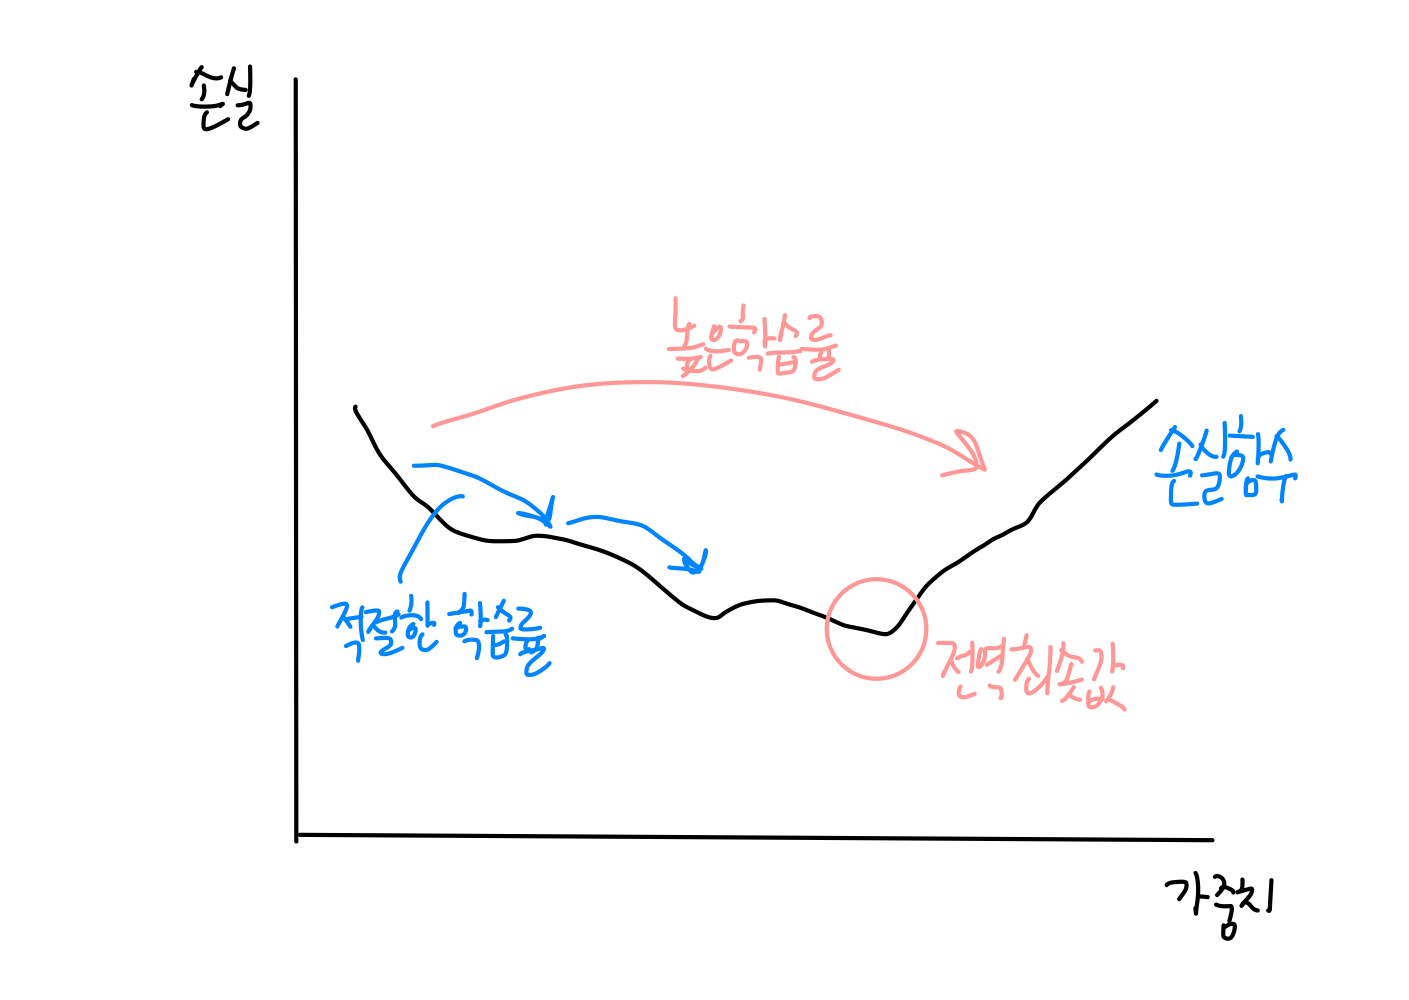

In [63]:
from IPython.display import Image
Image("./image/손실함수학습률.png", width=400)

In [30]:
    def __init__(self, learning_rate=0.1): # 기본 learning_rate 지정해주기
        # 가중치와 절편의 초기값을 셋팅하지 않음
        # __init__ 메서드에 손실함수의 결과값을 저장하기 위한 리스트를 만듦
        self.w = None
        self.b = None
        self.losses = []
        self.w_history=[] # 가중치 변화 관찰을 위한 추가
        self.lr = learning_rate # 학습률 추가

> 3. 가중치 기록하고 업데이트 양 조절하기

In [ ]:
- fit() 메서드에서 가중치가 바뀔 때마다 w_history 리스트에 가중치를 기록
- 가중치 변수 self.w의 값이 바뀔 때마다 그 값을 복사하여 w_history 리스트에 추가해야 함
- w_grad에 학습률 self.lr을 곱하는 연산이 추가되어 가중치 업데이트 양을 조절

In [ ]:
    def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy()) # 가중치 기록
        np.random.seed(42) #무작위 시드 지정 추가
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x))) # 인덱스 섞기
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)
                self.w -= self.lr*w_grad #기존에는 -=w_grad 였다면 self.lr을 곱해줌
                self.b -= b_grad
                a = np.clip(a, 1e-10, 1-1e-10)
                
                loss += -(y[i] * np.log(a) + (1-y[i]) * np.log(1-a))
            self.losses.append(loss/len(y))

> 4. 모델 훈련하고 평가하기

In [37]:
# 수정사항 반영

class SingleLayer: #클래스 이름 변경
    
    def __init__(self, learning_rate=0.1): # 기본 learning_rate 지정해주기
        # 가중치와 절편의 초기값을 셋팅하지 않음
        # __init__ 메서드에 손실함수의 결과값을 저장하기 위한 리스트를 만듦
        self.w = None
        self.b = None
        self.losses = []
        self.w_history=[] # 가중치 변화 관찰을 위한 추가
        self.lr = learning_rate # 학습률 추가
        
    def forpass(self, x):
        # 3장 선형회귀에서는 1차식의 표현으로 함수를 사용하지 않음
        # wi와 xi의 곱을 다 더하기 위해 np.sum 사용
        z = np.sum(x * self.w) + self.b
        return z
    
    def backprop(self, x, err):
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad
    
    def activation(self, z):
        a = 1 / (1 + np.exp(-z)) # 시그모이드 식
        return a

    # 위에 있던 fit 함수에서 np.random.permutation함수를 적용해서 인덱스를 섞어서 추출하도록 함
    def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy()) # 가중치 기록
        np.random.seed(42) #무작위 시드 지정 추가
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x))) # 인덱스 섞기
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)
                self.w -= self.lr*w_grad #기존에는 -=w_grad 였다면 self.lr을 곱해줌
                self.b -= b_grad
                self.w_history.append(self.w.copy())
                a = np.clip(a, 1e-10, 1-1e-10)
                
                loss += -(y[i] * np.log(a) + (1-y[i]) * np.log(1-a))
            self.losses.append(loss/len(y))
    
    # 위에 있던 함수를 아래 함수로 바꾸면서 score 함수를 추가함
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x] # 정방향 계산
        # 시그모이드 함수를 쓰지 않아도 z가 0보다 작으면 시그모이드 출력값은 0.5보다 작을 것
        # z가 0보다 크면 시그모이드 출력값이 0.5보다 커짐
        # z 값만 확인하면 되기 때문에 시그모이드를 사용하지 않음
        return np.array(z) > 0

    def score(self, x, y):
        return np.mean(self.predict(x)==y)

In [38]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


0.9120879120879121

- 바로 이전 검증세트로 평가한 모델의 정확도 (60% 정도)에 비해 상당히 많이 높아짐

> 5. 변경된 가중치 그래프로 그려보기

- layer1 객체의 w_history 변수에는 100번의 에포크 동안 변경된 가중치가 기록되어 잇음
- 이 때, 세 번째, 네 번째 요소 w[2], w[3]는 각각 mean perimeter 와 mean area 특성에 대한 가중치 임
- 그래프 그려보기

In [39]:
layer1.w_history

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1.

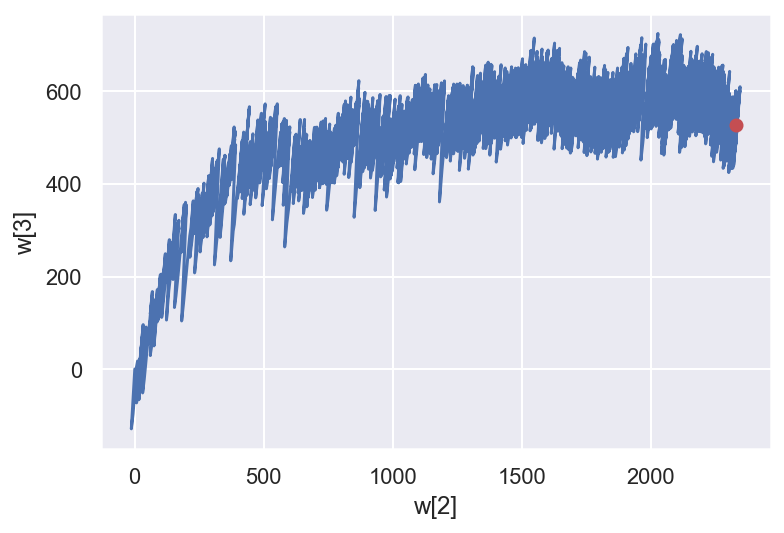

In [40]:
w2 = []
w3 = []
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

- mean area의 스케일이 커서 w3학습 과정에서 큰 폭으로 흔들리면서 변화하고 있음
- 반면 w2는 0부터 시작해서 조금씩 최적값에 가까워짐
- 'w3'에 대한 그라디언트가 크기 때문에 w3 축을 따라 가중치가 크게 요동치고 있다고 말할 수 있음
- 가중치의 최적값에 도달하는 동안 w3 값이 크게 요동치므로 모델이 불안정하게 수렴한다고 볼 수 있음
- 스케일링 조정으로 안정적인 수렴을 도모할 수 있음

## 스케일을 조정해 모델을 훈련합니다

- 스케일을 조정하는 방법은 많지만 신경망에서 자주 사용하는 방법 중 하나는 '표준화'
- 표준화는 특성값에서 평균을 빼고 표준편차로 나누면 됨
- 표준화 하면 평균이 0이고 분산이 1인 특성이 만들어짐
- 사이킷런에는 StandardScaler 클래스가 준비되어 있지만 학습을 위해 직접 구현

> 1. 넘파이로 표준화 구현하기

- 넘파이의 mean(), std() 함수로 평균과 표준편차를 계산하면 표준화를 쉽게 구현할 수 있음
- 표준화 구현 후 특성별로 스케일을 조정함
- mean()과 std() 함수의 axis 매개변수를 0으로 지정하면 2차원 배열의 열을 기준으로 통계치를 계산하여 하나의 행 벡터로 반환해줌
- 그런다음 훈련세트에서 평균을 빼고 표준편차로 나누면 됨

In [52]:
train_mean = np.mean(x_train, axis=0) # axis=0, 행 간의 평균 내는 것을 말함(열 기준 평균)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

- axis=0 열 기준 연산이 이해가 되지 않아 아래 arr를 만들어서 해봄 (행 간의 평균이라고 생각하면 더 쉬울것..)

In [46]:
arr = [[2,4,6],[4,6,8],[8,10,12]]

In [48]:
np.mean(arr, axis=0)

array([4.66666667, 6.66666667, 8.66666667])

> 2. 모델 훈련하기

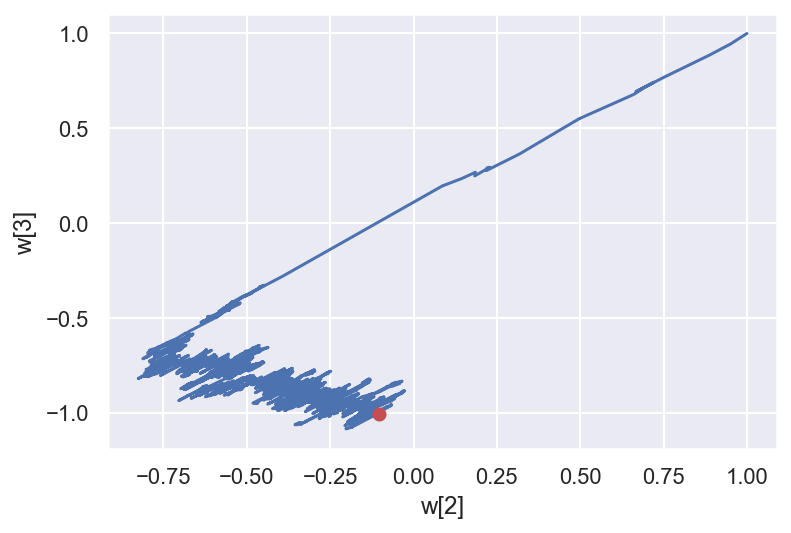

In [54]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2 = []
w3 = []
for w in layer2.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

- w2와 w3의 변화 비율이 비슷하기 때문에 대각선 방향으로 가중치가 이동함

> 3. 모델 성능 평가하기

In [55]:
layer2.score(x_val, y_val)

0.37362637362637363

- 앗 성능 무슨일..

> 4. 훈련세트와 검증세트의 스케일이 다르다!

In [56]:
# 검증세트도 표준화 처리하기
val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean) / val_std
layer2.score(x_val_scaled, y_val)

0.967032967032967

- 검증세트에 대한 정확도가 약 96%! 
- 하지만 함정이 있다네요

## 스케일 조정 후 실수하기 쉬운 함정을 알아봅니다

- 앞에서 언급한 함정은 '훈련세트와 검증세트가 다른 비율로 스케일이 조정된 경우'
- 산점도를 보면서 설명
- 제대로 스케일링 했다면 원본/ 검증세트의 산점도와 전처리 후의 산점도가 같아야 함

> 1. 원본 훈련세트와 검증 세트로 산점도 그리기

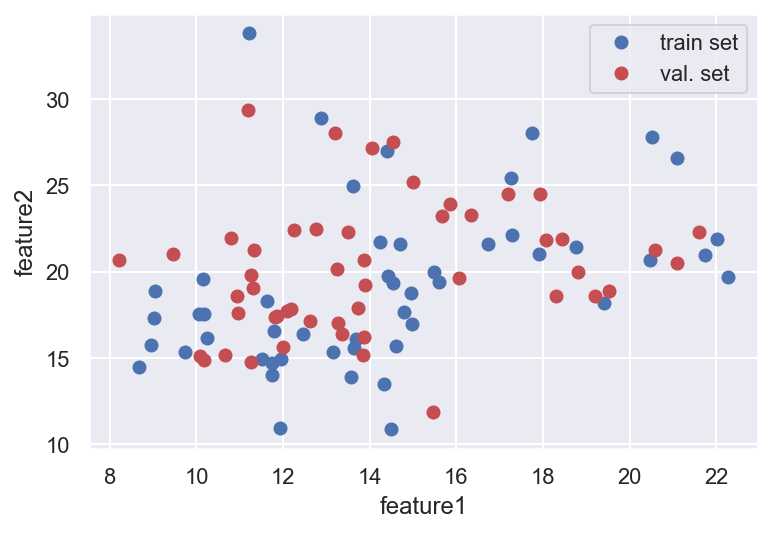

In [57]:
# 파란점이 훈련세트 빨간 점이 검증세트
plt.plot(x_train[:50,0], x_train[:50, 1], 'bo')
plt.plot(x_val[:50, 0], x_val[:50, 1], 'ro')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.legend(['train set', 'val. set'])
plt.show()

> 2. 전처리한 훈련 세트와 검증 세트로 산점도 그리기

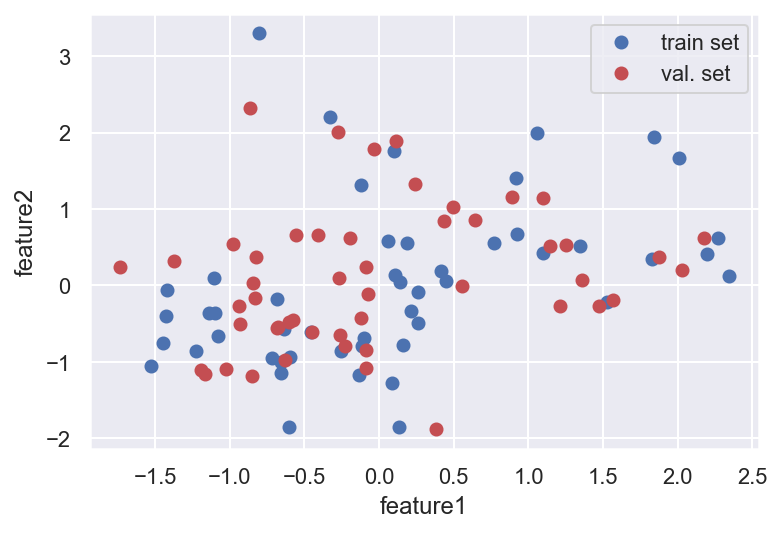

In [58]:
# 파란점이 훈련세트 빨간 점이 검증세트
plt.plot(x_train_scaled[:50,0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.legend(['train set', 'val. set'])
plt.show()

- 거의 비슷하지만 훈련 세트와 검증 세트가 다른 비율로 변환되었음을 확이할 수 있음
- 원본set에서 (18,25) 부근과 전처리set에서 (1.0, 1-2) 부근
- (14, 27) 부근과 (0,2)부근

> 3. 올바르게 검증세트 전처리하기

- 검증세트와 훈련세트의 스케일이 다른 비율로 조정되면 모델에 적용된 알고리즘들이 검증 세트의 샘플데이터를 잘 못 인식함
- 검증세트와 훈련세트를 같은 비율로 전처리 해야함
- 훈련세트의 평균과 표준편차를 사용해서 검증세트를 변환하면 됨

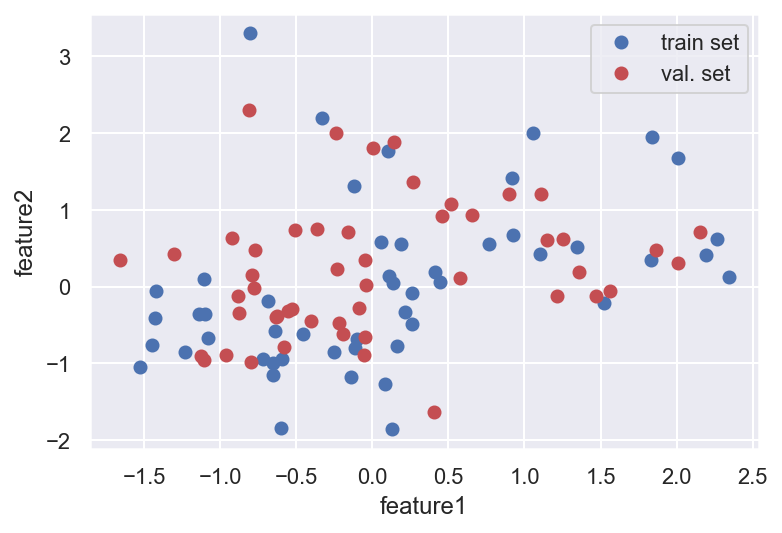

In [59]:
x_val_scaled = (x_val - train_mean) / train_std
plt.plot(x_train_scaled[:50,0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.legend(['train set', 'val. set'])
plt.show()

> 4. 모델 평가하기

In [60]:
layer2.score(x_val_scaled, y_val)

0.967032967032967

- 위스콘신 유방암 데이터 세트는 크지 않기때문에 검증세트 전처리 전과 후의 성능이 동일
- 즉, 동일한 개수의 샘플을 올바르게 예측함
- 하지만 검증세트가 클 경우 성능 차이가 발생할 수 있음